In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested
from phe import *
from phe import map_data as phe_map_data
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

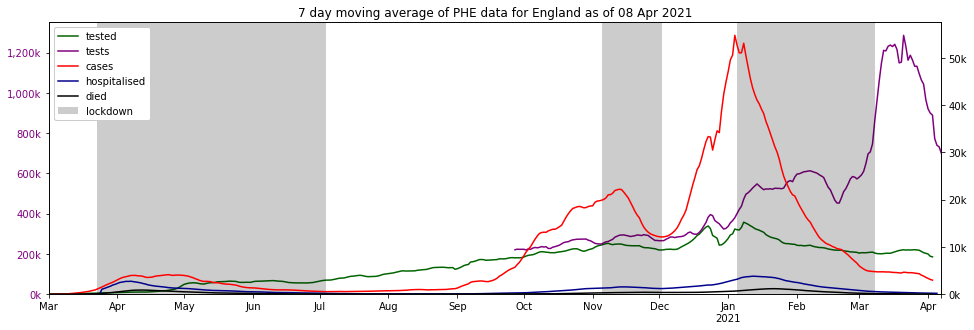

In [2]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

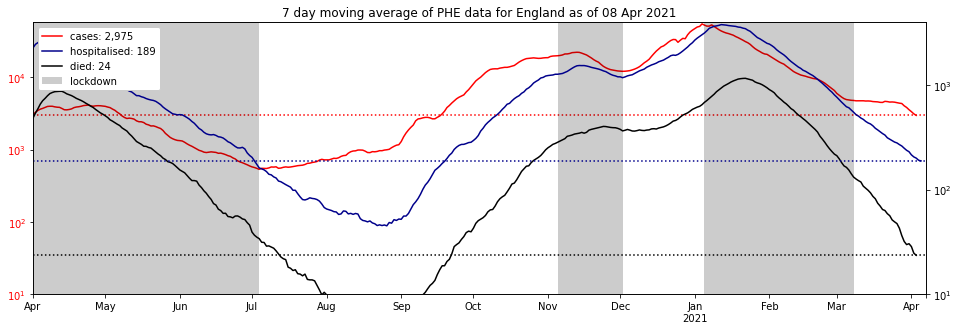

In [3]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

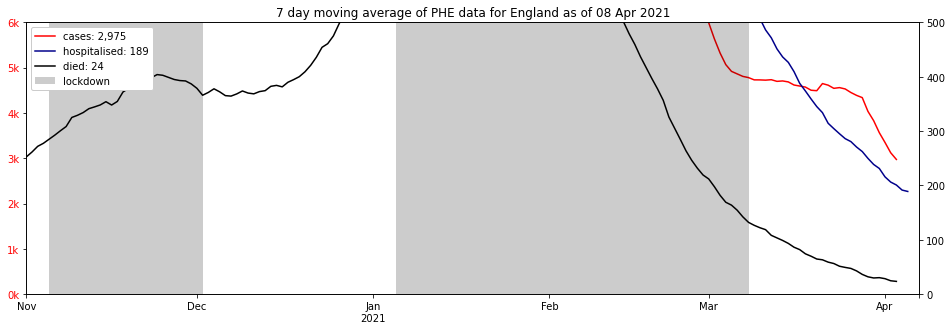

In [4]:
plot_summary(earliest_date='2020-11-01', show_latest=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter, left_ymax=6_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=500)

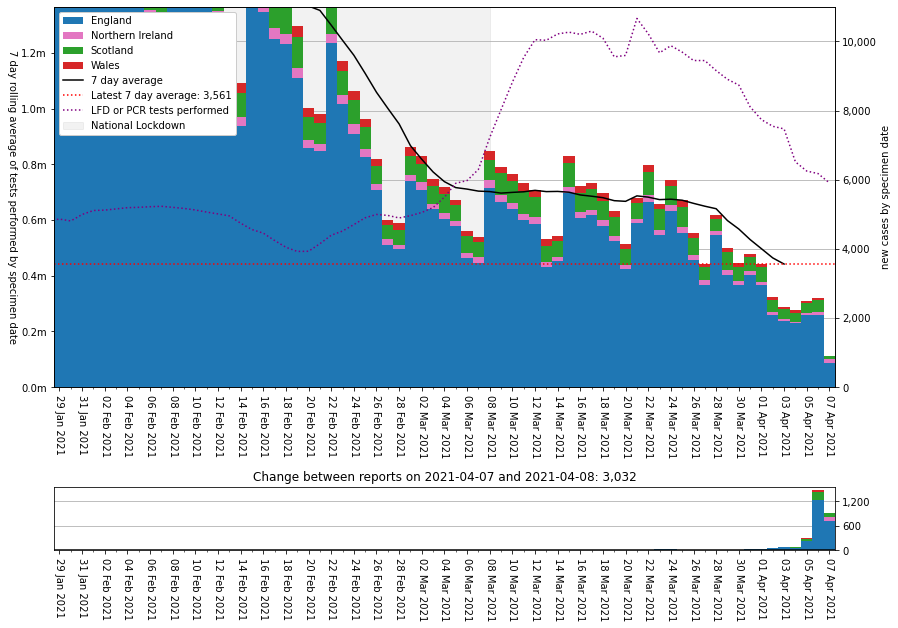

In [5]:
plot_areas(for_date, 'cases_nations', ylim=11_000, earliest='2021-01-29')

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,4933018.0,26879123.0,21946105.0,56286961,8.764051,38.989678,52.246271
1,Northern Ireland,N92000002,173772.0,799410.0,625638.0,1893667,9.176481,33.038438,57.785080
2,Scotland,S92000003,500376.0,2608831.0,2108455.0,5463300,9.158860,38.593066,52.248074
3,Wales,W92000004,484739.0,1519760.0,1035021.0,3152879,15.374488,32.827806,51.797706


'partial: 31,807,124 (47.6%), full: 6,091,905'

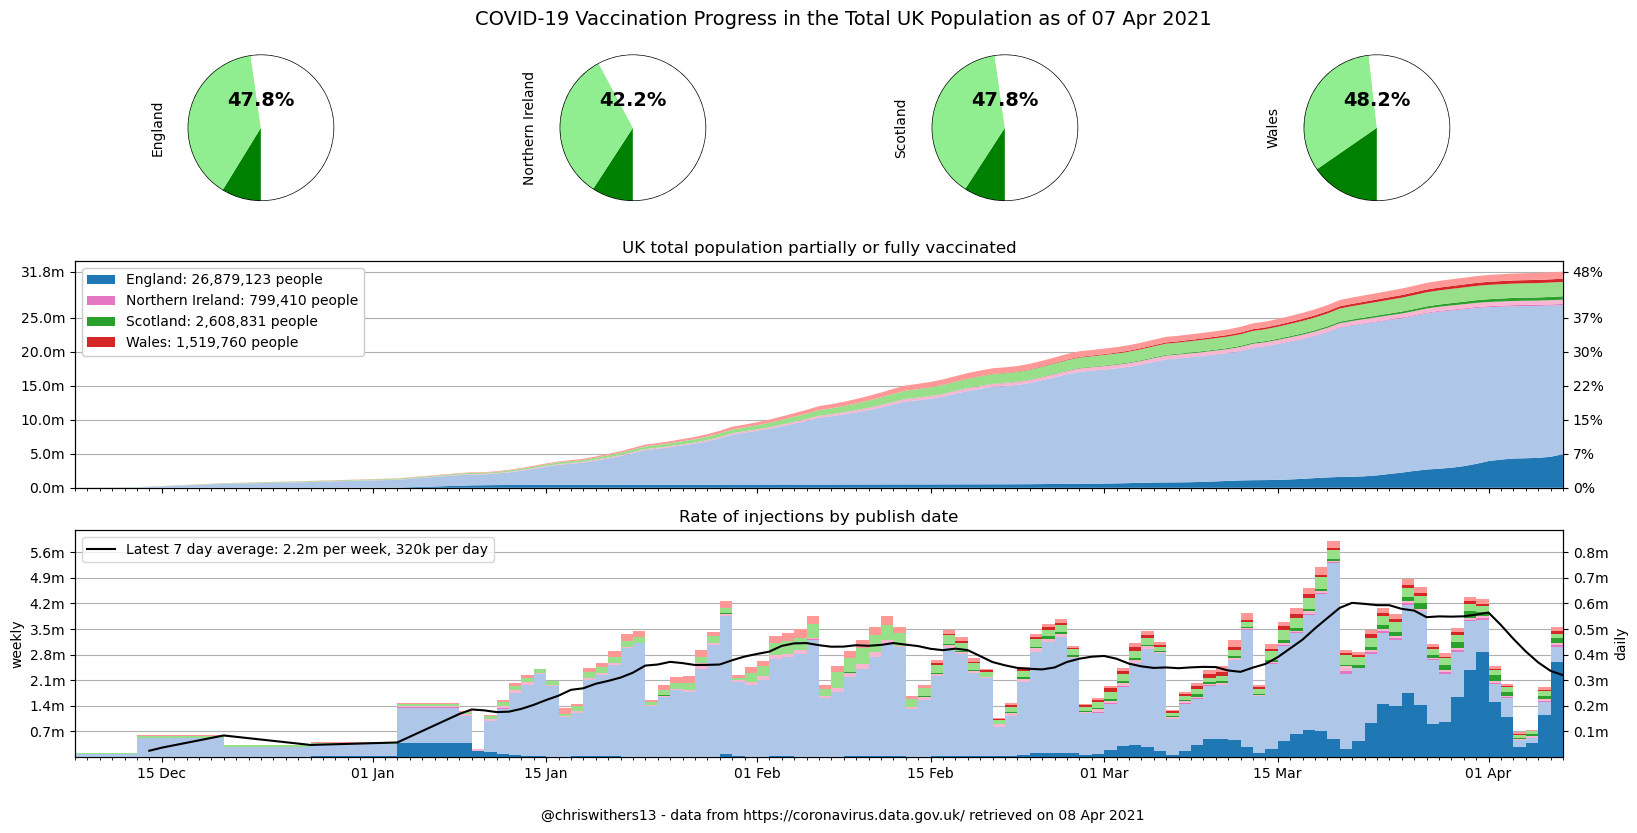

In [6]:
results = vaccination_dashboard(show_partial=True)
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

In [7]:
vaccination_changes()

,,First Dose (New),Second Dose (New),Complete (New),First Dose (Total),Second Dose (Total),Complete (Total)
,,,,,,,
England,07 Apr 21,"+58,962","+372,241","+372,241","+26,879,123","+4,933,018","+4,933,018"
Northern Ireland,07 Apr 21,"+8,550","+5,849","+5,849","+799,410","+173,772","+173,772"
Scotland,07 Apr 21,"+14,899","+21,137","+21,137","+2,608,831","+500,376","+500,376"
Wales,07 Apr 21,"+17,119","+9,169","+9,169","+1,519,760","+484,739","+484,739"


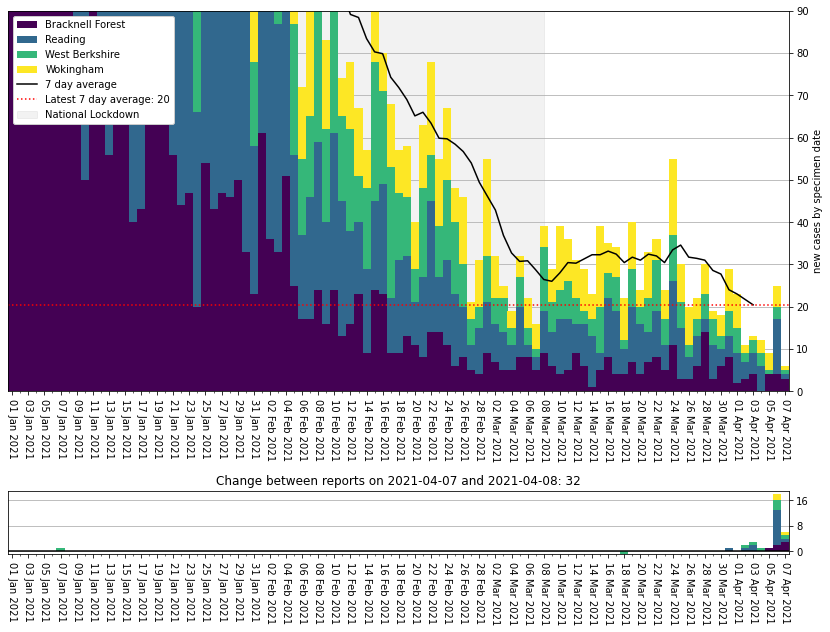

In [8]:
plot_areas(for_date, areas=my_areas, earliest='2021-01-01', ylim=90)

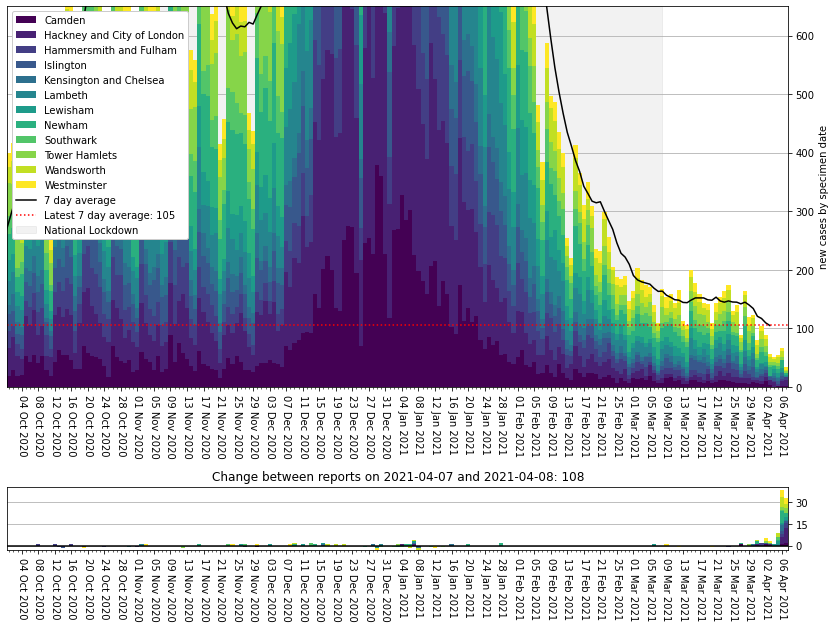

In [9]:
plot_areas(for_date, areas=london_areas, ylim=650)

In [10]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [11]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
S12000005,Clackmannanshire,137.757082,71.0,2021-04-07
E07000174,Mansfield,101.543275,111.0,2021-04-07
E07000150,Corby,99.698136,72.0,2021-04-07
E08000016,Barnsley,83.446080,206.0,2021-04-07
E06000016,Leicester,71.141425,252.0,2021-04-07
E08000036,Wakefield,70.339236,245.0,2021-04-07
E06000032,Luton,68.997240,147.0,2021-04-07
E08000017,Doncaster,68.293309,213.0,2021-04-07
S12000050,North Lanarkshire,67.082638,229.0,2021-04-07


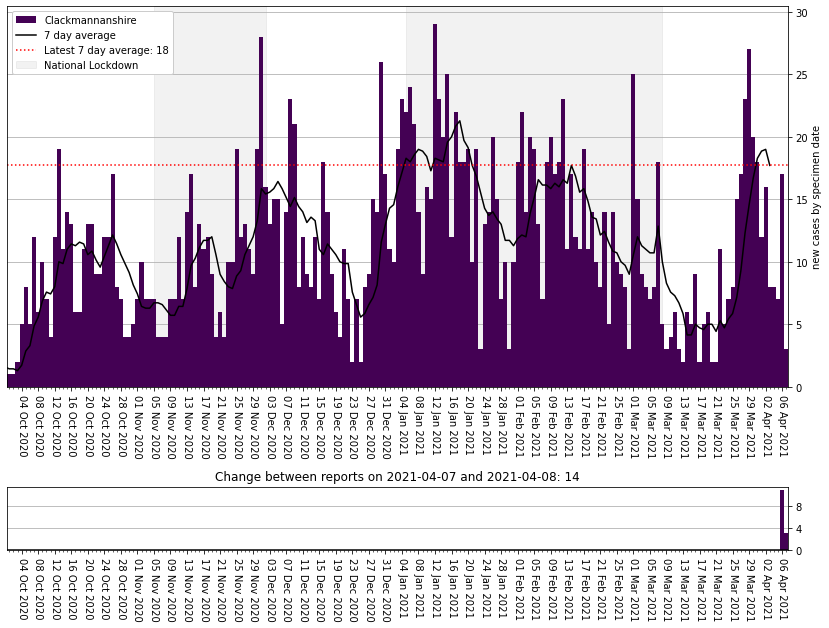

In [12]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [13]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000035,Leeds,61.149433,485.0,2021-04-07
S12000049,Glasgow City,61.757645,391.0,2021-04-07
E08000019,Sheffield,62.066878,363.0,2021-04-07
E08000032,Bradford,66.879594,361.0,2021-04-07
E08000025,Birmingham,25.398138,290.0,2021-04-07
E08000034,Kirklees,60.029060,264.0,2021-04-07
E06000016,Leicester,71.141425,252.0,2021-04-07
E08000036,Wakefield,70.339236,245.0,2021-04-07
E08000003,Manchester,41.602003,230.0,2021-04-07


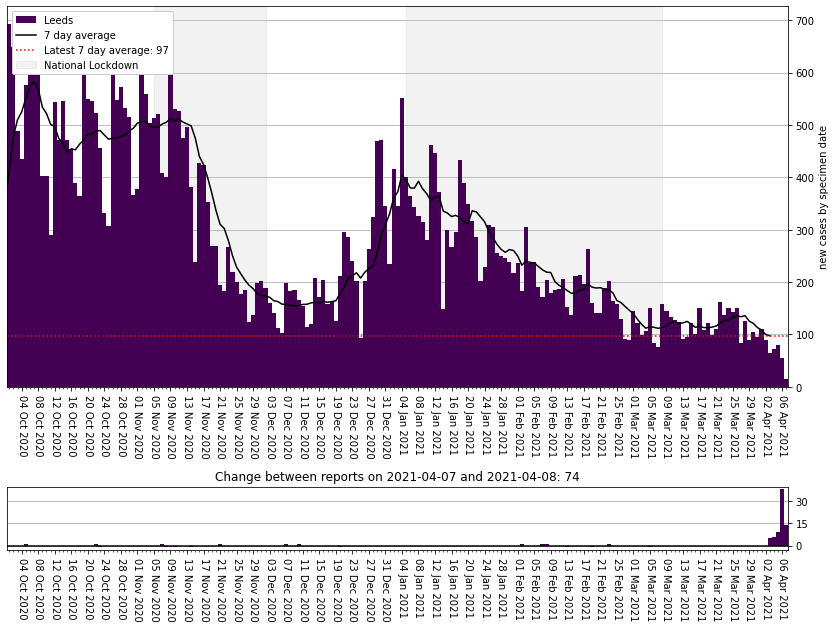

In [14]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [15]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 1.5
phe_max = 0.18

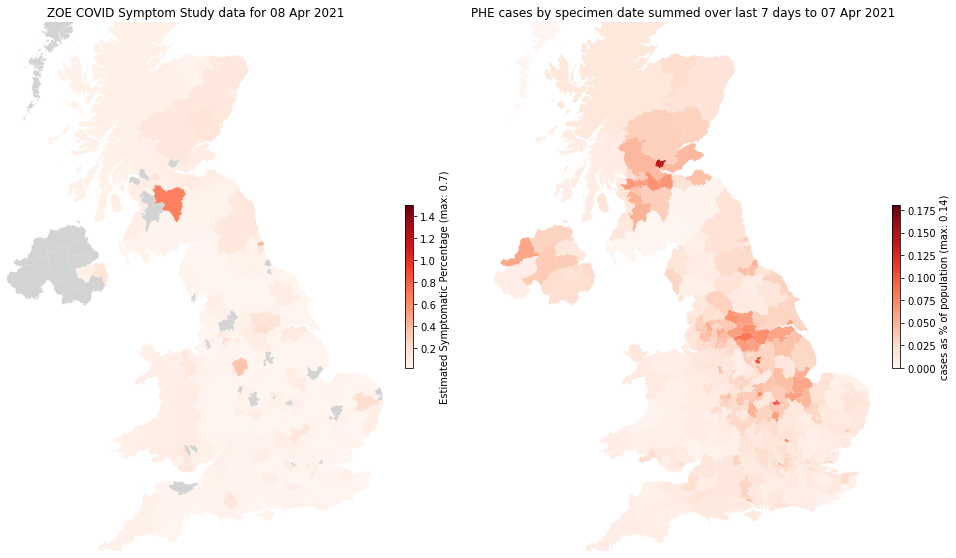

In [16]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [17]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...